In [8]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [9]:
import numpy as np
import matplotlib.pyplot as plt
import datetime
import copy
import time

import sys
sys.path.append('../../')

from data.processing import get_data

import models

from main.seir.fitting import single_fitting_cycle
from main.seir.forecast import get_forecast, forecast_all_trials, create_all_trials_csv, create_decile_csv_new, predict_r0_multipliers, save_r0_mul
from main.seir.sensitivity import calculate_sensitivity_and_plot
from utils.generic.create_report import save_dict_and_create_report
from utils.generic.config import read_config
from utils.generic.enums import Columns
from utils.fitting.loss import Loss_Calculator
#from utils.generic.logging import log_wandb
from viz import plot_forecast, plot_top_k_trials, plot_ptiles, plot_r0_multipliers, plot_daily_trend

import yaml

In [10]:
predictions_dict = {}

In [11]:
# config_filename = 'jharkhand.yaml'
# config_filename = 'ranchi.yaml'
config_filename = 'east singhbhum.yaml'
# config_filename = 'dhanbad.yaml'
# config_filename = 'bokaro.yaml'
# config_filename = 'deogarh.yaml'
# config_filename = 'ramgarh.yaml'
config = read_config(config_filename)

In [12]:
output_folder = '../../misc/reports/{}'.format(datetime.datetime.now().strftime("%Y_%m%d_%H%M%S")) + '_' + config_filename.split('.')[0]

## Perform M0 fit

In [13]:
train_period, val_period, test_period = config['fitting']['split']['train_period'], config['fitting']['split']['val_period'], config['fitting']['split']['test_period']

m0_params = copy.deepcopy(config['fitting'])
m1_params = copy.deepcopy(config['fitting'])
m2_params = copy.deepcopy(config['fitting'])

m1_params['split']['val_period'] = 0
m1_params['split']['test_period'] = 0

m2_params['split']['test_period'] = 0

predictions_dict['fitting_date'] = datetime.datetime.now().strftime("%Y-%m-%d")

Performing m1 fit ..
fetching from athenadb...
loading from ../../misc/cache/dataframes_ts_08122020_athena.pkl
splitting data ..
splitting data ..
         state       district       date  total  active  recovered  deceased  \
0    Jharkhand  East Singbhum 2020-03-31      0       0          0         0   
1    Jharkhand  East Singbhum 2020-04-01      0       0          0         0   
2    Jharkhand  East Singbhum 2020-04-02      0       0          0         0   
3    Jharkhand  East Singbhum 2020-04-03      0       0          0         0   
4    Jharkhand  East Singbhum 2020-04-04      0       0          0         0   
..         ...            ...        ...    ...     ...        ...       ...   
246  Jharkhand  East Singbhum 2020-12-02  17219     294      16573       352   
247  Jharkhand  East Singbhum 2020-12-03  17239     296      16591       352   
248  Jharkhand  East Singbhum 2020-12-04  17261     296      16612       353   
249  Jharkhand  East Singbhum 2020-12-05  17280     2

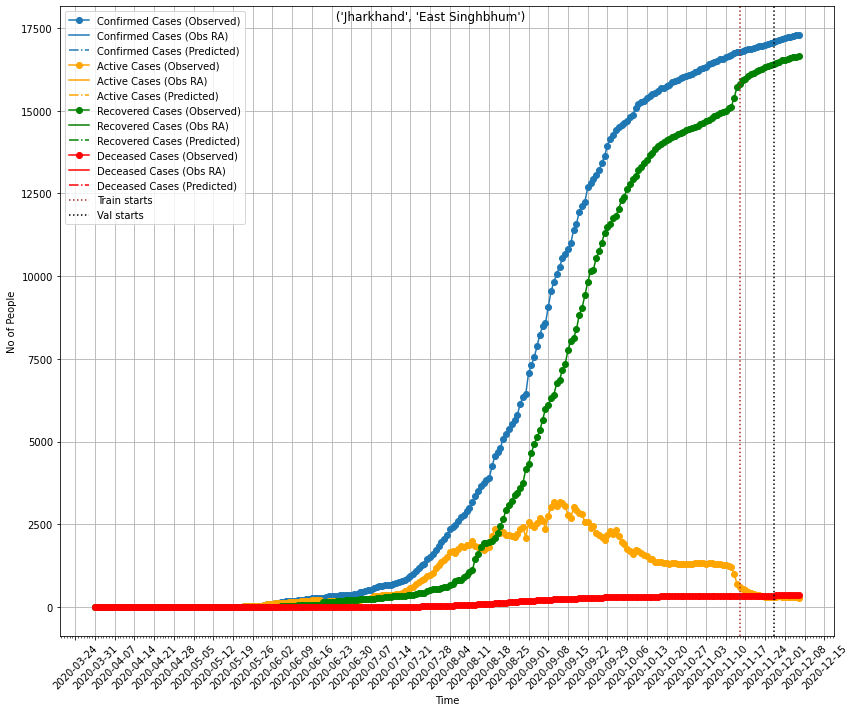

In [14]:
predictions_dict['m0'] = single_fitting_cycle(**m0_params)

In [15]:
config_0 = copy.deepcopy(config)
config_0['uncertainty']['uncertainty_params']['which_fit']='m0'

In [16]:
predictions_dict['m0']['trials_processed'] = forecast_all_trials(predictions_dict, train_fit='m0', 
                                                                 model=config_0['fitting']['model'], 
                                                                 forecast_days=config['forecast']['forecast_days'])

10it [00:00, 95.58it/s]getting forecasts ..
1000it [00:07, 129.19it/s]


In [17]:
uncertainty_args = {'predictions_dict': predictions_dict, **config_0['uncertainty']['uncertainty_params']}
uncertainty = config_0['uncertainty']['method'](**uncertainty_args)

100%|██████████| 100/100 [00:46<00:00,  2.17trial/s, best loss: 1.1434475265387536]


In [18]:
predictions_dict['m0']['forecasts'] = {}

uncertainty_forecasts = uncertainty.get_forecasts()
for key in uncertainty_forecasts.keys():
    predictions_dict['m0']['forecasts'][key] = uncertainty_forecasts[key]['df_prediction']
    
predictions_dict['m0']['forecasts']['ensemble_mean'] = uncertainty.ensemble_mean_forecast

predictions_dict['m0']['forecasts']['best'] = get_forecast(predictions_dict, train_fit='m0', 
                                                           model=config['fitting']['model'], 
                                                           days=config['forecast']['forecast_days'])

getting forecasts ..


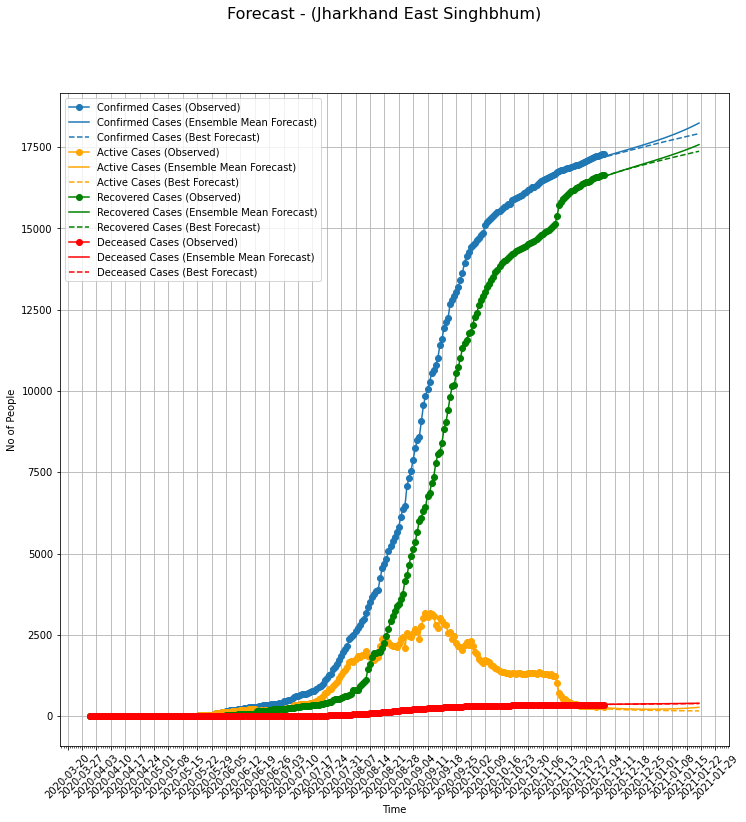

In [19]:
predictions_dict['m0']['plots']['forecast_ensemble_mean_best'] = plot_forecast(predictions_dict,
            (config['fitting']['data']['dataloading_params']['state'], config['fitting']['data']['dataloading_params']['district']), which_fit='m0', fits_to_plot =['ensemble_mean', 'best'],
            error_bars=True) 

## Performing M1 and M2 fits

Performing m2 fit ..
fetching from athenadb...
loading from ../../misc/cache/dataframes_ts_08122020_athena.pkl
splitting data ..
splitting data ..
         state       district       date  total  active  recovered  deceased  \
0    Jharkhand  East Singbhum 2020-03-31      0       0          0         0   
1    Jharkhand  East Singbhum 2020-04-01      0       0          0         0   
2    Jharkhand  East Singbhum 2020-04-02      0       0          0         0   
3    Jharkhand  East Singbhum 2020-04-03      0       0          0         0   
4    Jharkhand  East Singbhum 2020-04-04      0       0          0         0   
..         ...            ...        ...    ...     ...        ...       ...   
246  Jharkhand  East Singbhum 2020-12-02  17219     294      16573       352   
247  Jharkhand  East Singbhum 2020-12-03  17239     296      16591       352   
248  Jharkhand  East Singbhum 2020-12-04  17261     296      16612       353   
249  Jharkhand  East Singbhum 2020-12-05  17280     2

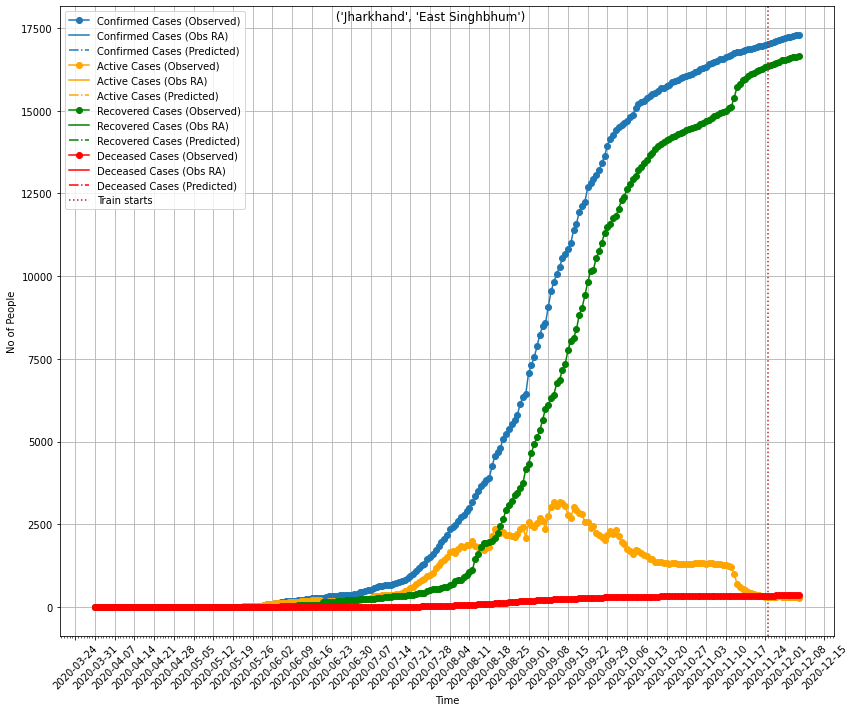

In [20]:
predictions_dict['m1'] = single_fitting_cycle(**m1_params) 

Performing m1 fit ..
fetching from athenadb...
loading from ../../misc/cache/dataframes_ts_08122020_athena.pkl
splitting data ..
splitting data ..
         state       district       date  total  active  recovered  deceased  \
0    Jharkhand  East Singbhum 2020-03-31      0       0          0         0   
1    Jharkhand  East Singbhum 2020-04-01      0       0          0         0   
2    Jharkhand  East Singbhum 2020-04-02      0       0          0         0   
3    Jharkhand  East Singbhum 2020-04-03      0       0          0         0   
4    Jharkhand  East Singbhum 2020-04-04      0       0          0         0   
..         ...            ...        ...    ...     ...        ...       ...   
246  Jharkhand  East Singbhum 2020-12-02  17219     294      16573       352   
247  Jharkhand  East Singbhum 2020-12-03  17239     296      16591       352   
248  Jharkhand  East Singbhum 2020-12-04  17261     296      16612       353   
249  Jharkhand  East Singbhum 2020-12-05  17280     2

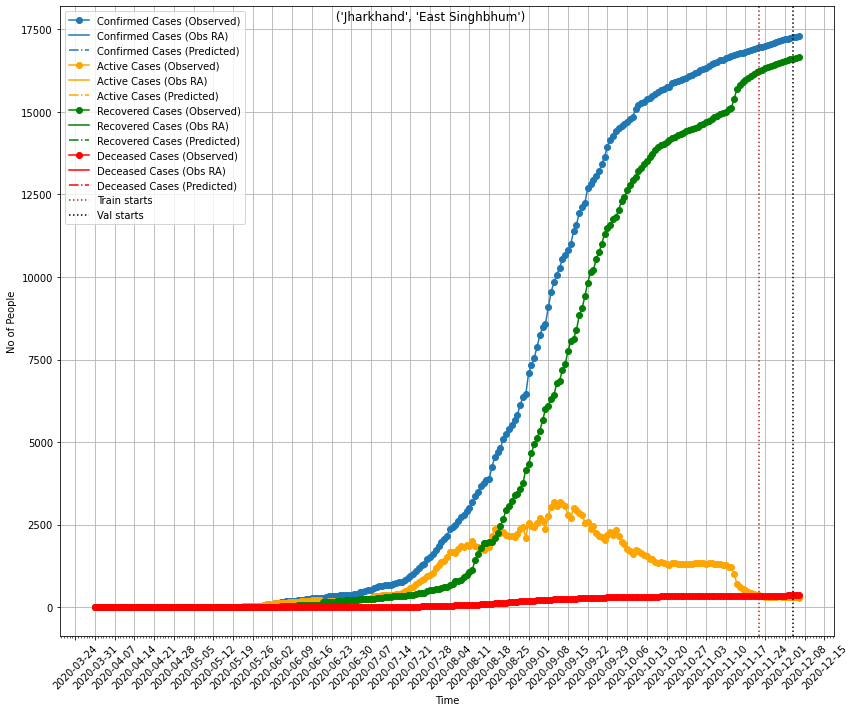

In [21]:
predictions_dict['m2'] = single_fitting_cycle(**m2_params)

In [22]:
predictions_dict['m0']['best_params']

{'E_hosp_ratio': 0.09377325714556112,
 'I_hosp_ratio': 0.16718158347314654,
 'P_fatal': 0.03188227791401817,
 'T_inc': 4.155983943594491,
 'T_inf': 3.568794420818816,
 'T_recov': 10.059147193580625,
 'T_recov_fatal': 26.129261474507604,
 'lockdown_R0': 0.9811646578189566}

In [23]:
predictions_dict['m1']['best_params']

{'E_hosp_ratio': 0.19367751281729267,
 'I_hosp_ratio': 0.27800587073210403,
 'P_fatal': 0.028727898977140683,
 'T_inc': 4.955490935844399,
 'T_inf': 3.4856935478375304,
 'T_recov': 14.648131056031115,
 'T_recov_fatal': 39.32813591336188,
 'lockdown_R0': 0.9979961019015574}

In [24]:
predictions_dict['m2']['best_params']

{'E_hosp_ratio': 0.2158860852270257,
 'I_hosp_ratio': 0.32857887783586043,
 'P_fatal': 0.015237871539250457,
 'T_inc': 4.681352715524522,
 'T_inf': 3.6813181063441034,
 'T_recov': 11.443320374946845,
 'T_recov_fatal': 24.024872456233133,
 'lockdown_R0': 1.1748097579569496}

## Loss Dataframes

## M0 Loss Dataframe

In [25]:
predictions_dict['m0']['df_loss']

train       val      test
total      0.115547  0.321259  0.546902
active      4.25762   9.79503   17.1318
recovered  0.206125  0.160122  0.287686
deceased   0.215596  0.760548   1.21685

### M1 Loss DataFrame

In [26]:
predictions_dict['m1']['df_loss']

train
total      0.141799
active      1.49014
recovered  0.152445
deceased   0.070956

### M2 Loss DataFrame

In [27]:
predictions_dict['m2']['df_loss']

train        val
total       0.116478   0.152383
active       3.09234    3.78649
recovered   0.129054  0.0941737
deceased   0.0475512  0.0944287

## Sensitivity Plot

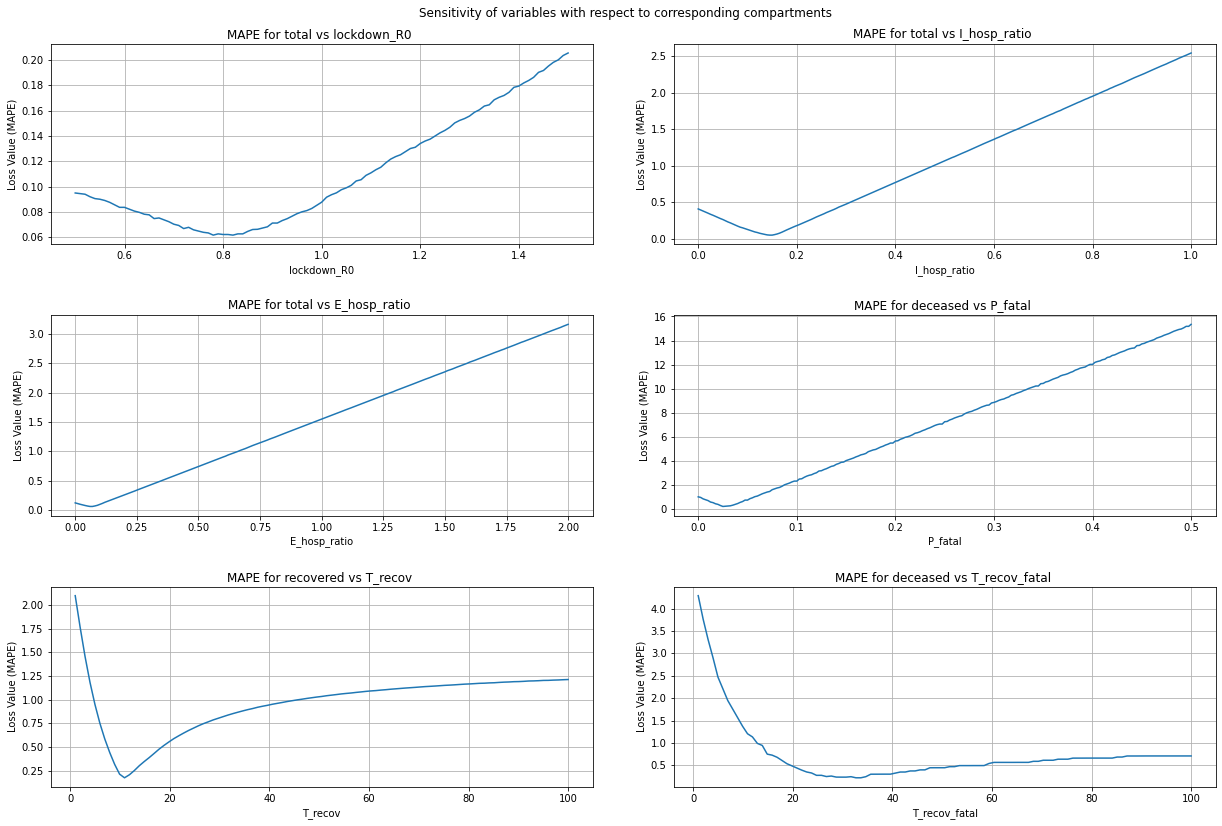

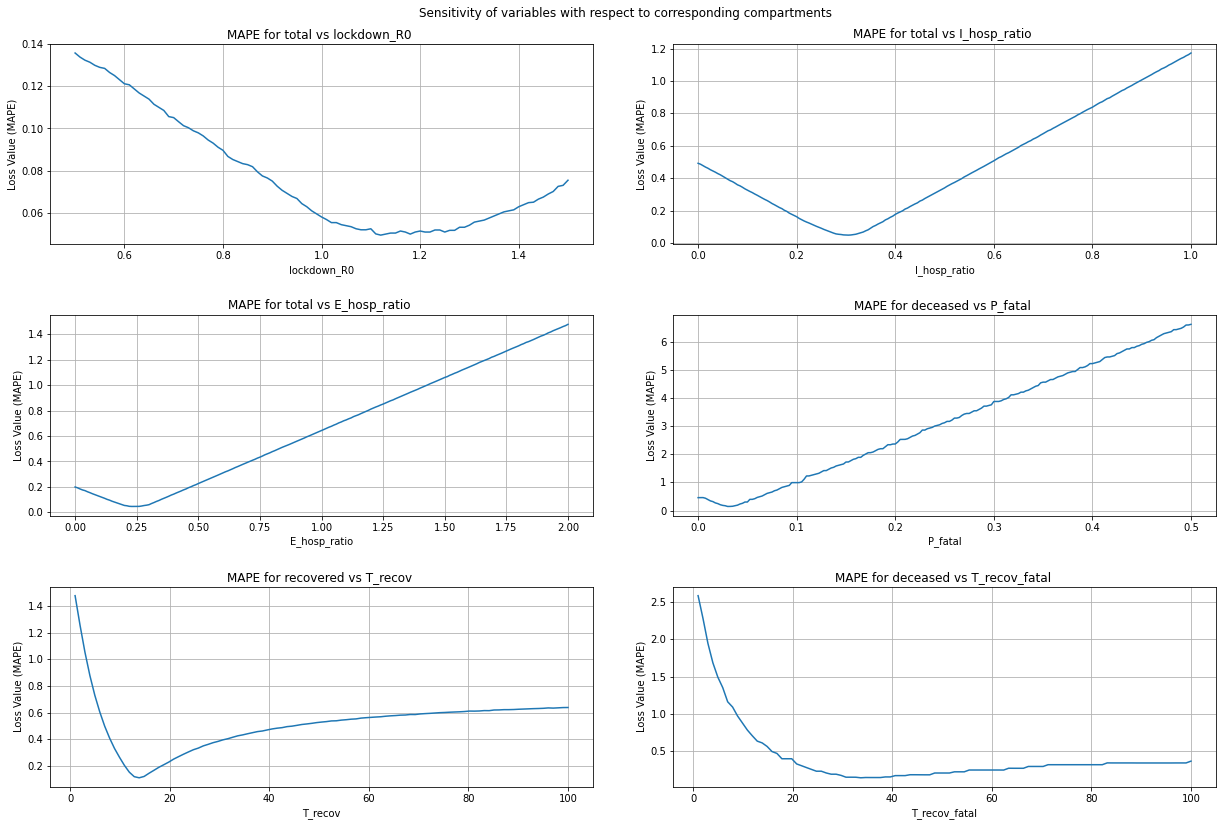

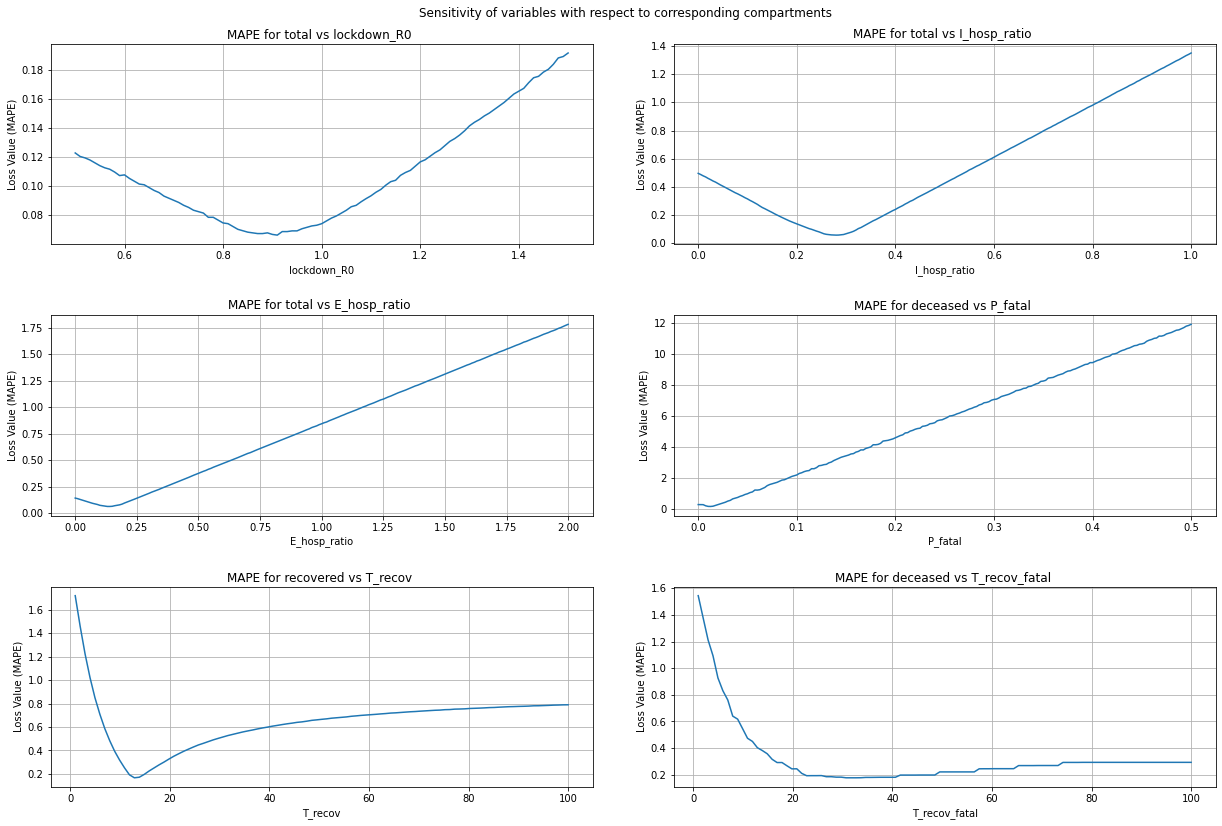

In [28]:
predictions_dict['m0']['plots']['sensitivity'], _, _ = calculate_sensitivity_and_plot(predictions_dict, config, which_fit='m0')
predictions_dict['m1']['plots']['sensitivity'], _, _ = calculate_sensitivity_and_plot(predictions_dict, config, which_fit='m1')
predictions_dict['m2']['plots']['sensitivity'], _, _ = calculate_sensitivity_and_plot(predictions_dict, config, which_fit='m2')

## Plot Forecasts

In [29]:
'''
# M2 based forecasting for the next train_period + test_period + forecast_period (no validation period)
predictions_dict['m0']['forecasts'] = {}
predictions_dict['m0']['forecasts']['best'] = get_forecast(predictions_dict, train_fit='m0', 
                                                           model=config['fitting']['model'], 
                                                           days=config['forecast']['forecast_days']
'''

"\n# M2 based forecasting for the next train_period + test_period + forecast_period (no validation period)\npredictions_dict['m0']['forecasts'] = {}\npredictions_dict['m0']['forecasts']['best'] = get_forecast(predictions_dict, train_fit='m0', \n                                                           model=config['fitting']['model'], \n                                                           days=config['forecast']['forecast_days']\n"

In [30]:
# M2 based forecasting for the next train_period + test_period + forecast_period (no validation period)
predictions_dict['m1']['forecasts'] = {}
predictions_dict['m1']['forecasts']['best'] = get_forecast(predictions_dict, train_fit='m1', 
                                                           model=config['fitting']['model'], 
                                                           days=config['forecast']['forecast_days'])

getting forecasts ..


In [31]:
# M2 based forecasting for the next train_period + test_period + forecast_period (no validation period)
predictions_dict['m2']['forecasts'] = {}
predictions_dict['m2']['forecasts']['best'] = get_forecast(predictions_dict, train_fit='m2', 
                                                           model=config['fitting']['model'], 
                                                           days=config['forecast']['forecast_days'])

getting forecasts ..


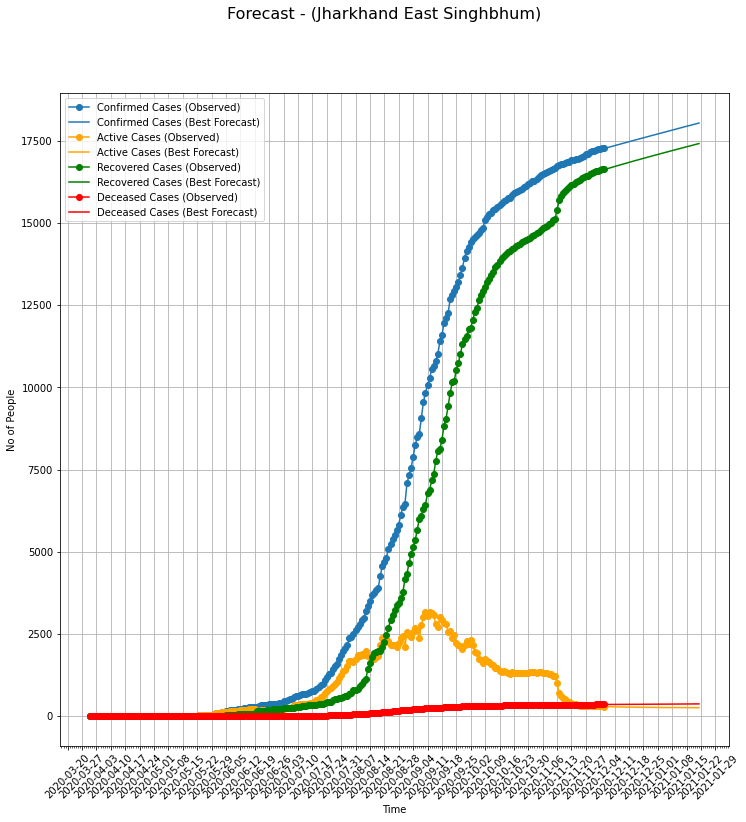

In [32]:
# Predictions plotted are for the most recent train_period days + test_period + forecast_period (no validation_period)
predictions_dict['m1']['plots']['forecast_best'] = plot_forecast(predictions_dict,
            (config['fitting']['data']['dataloading_params']['state'], config['fitting']['data']['dataloading_params']['district']), which_fit='m1',
            error_bars=True)

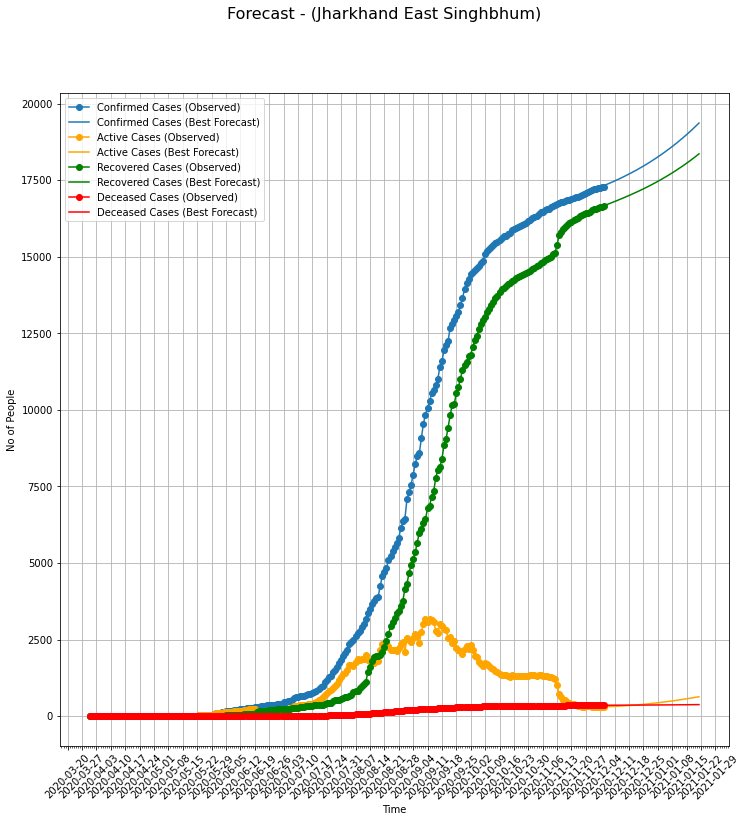

In [33]:
# Predictions plotted are for the most recent train_period days + test_period + forecast_period (no validation_period)
predictions_dict['m2']['plots']['forecast_best'] = plot_forecast(predictions_dict,
            (config['fitting']['data']['dataloading_params']['state'], config['fitting']['data']['dataloading_params']['district']), which_fit = 'm2',
            error_bars=True)

In [34]:
predictions_dict['m1']['trials_processed'] = forecast_all_trials(predictions_dict, train_fit='m1', 
                                                                 model=config['fitting']['model'], 
                                                                 forecast_days=config['forecast']['forecast_days'])

13it [00:00, 128.85it/s]getting forecasts ..
1000it [00:07, 130.26it/s]


In [35]:
predictions_dict['m2']['trials_processed'] = forecast_all_trials(predictions_dict, train_fit='m2', 
                                                                 model=config['fitting']['model'], 
                                                                 forecast_days=config['forecast']['forecast_days'])

15it [00:00, 143.18it/s]getting forecasts ..
1000it [00:06, 143.80it/s]


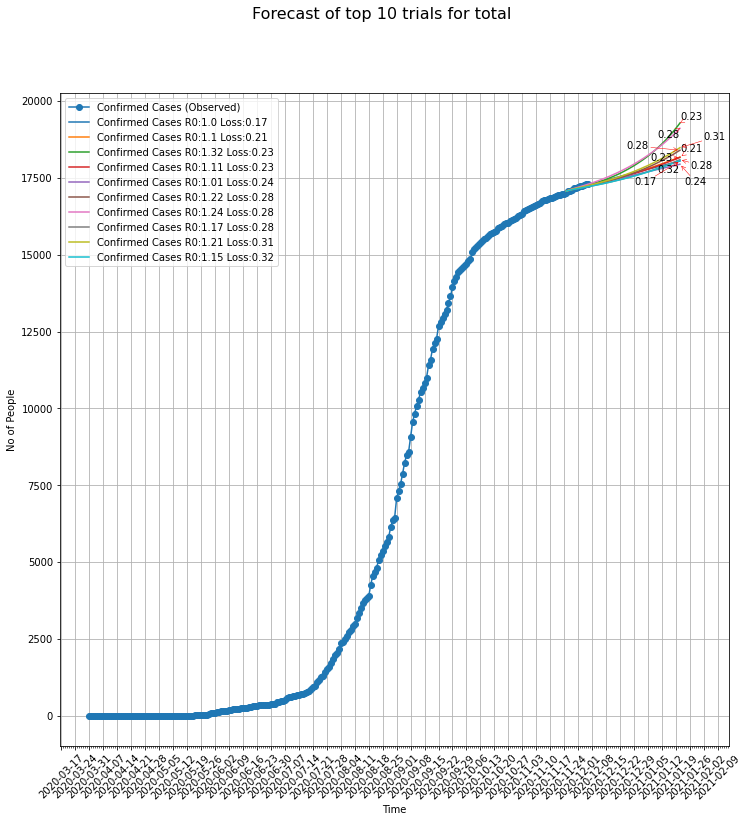

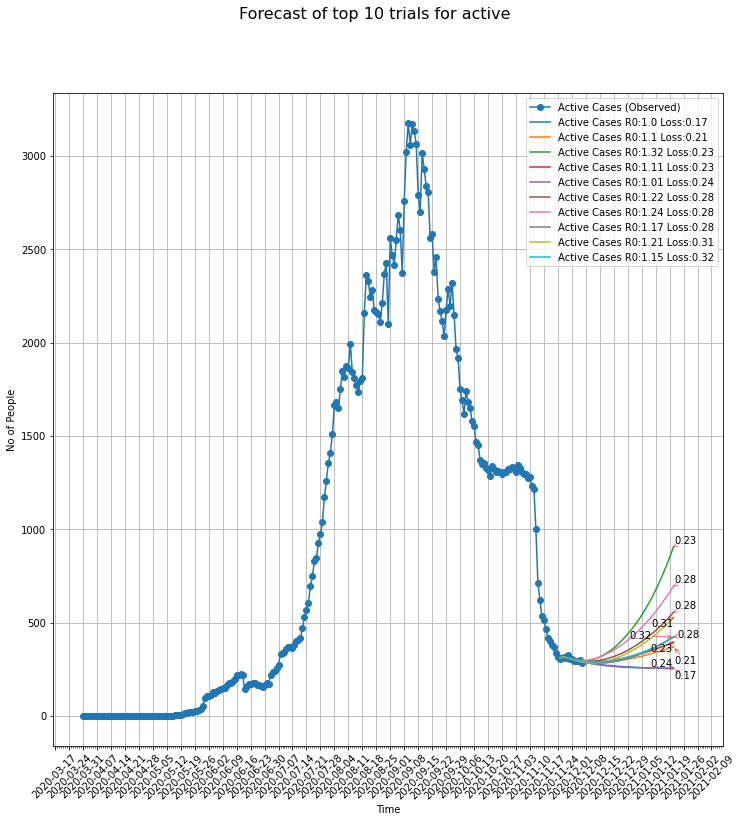

In [36]:
kforecasts = plot_top_k_trials(predictions_dict, train_fit='m1',
                               k=config['forecast']['num_trials_to_plot'],
                               which_compartments=config['forecast']['plot_topk_trials_for_columns'])

In [37]:
predictions_dict['m1']['plots']['forecasts_topk'] = {}
for column in config['forecast']['plot_topk_trials_for_columns']:
    predictions_dict['m1']['plots']['forecasts_topk'][column.name] = kforecasts[column]

## Uncertainty + Uncertainty Forecasts

In [38]:
uncertainty_args = {'predictions_dict': predictions_dict, **config['uncertainty']['uncertainty_params']}
uncertainty = config['uncertainty']['method'](**uncertainty_args)

100%|██████████| 100/100 [00:46<00:00,  2.17trial/s, best loss: 0.8401500718709985]


In [39]:
uncertainty.beta_loss

{'active': 2.980849180135498,
 'recovered': 0.17488937410059466,
 'deceased': 0.08826081352824511,
 'total': 0.11660091971965621}

In [40]:
uncertainty_forecasts = uncertainty.get_forecasts()
for key in uncertainty_forecasts.keys():
    predictions_dict['m2']['forecasts'][key] = uncertainty_forecasts[key]['df_prediction']
    
predictions_dict['m2']['forecasts']['ensemble_mean'] = uncertainty.ensemble_mean_forecast

In [41]:
predictions_dict['m2']['beta'] = uncertainty.beta
predictions_dict['m2']['beta_loss'] = uncertainty.beta_loss
predictions_dict['m2']['deciles'] = uncertainty_forecasts

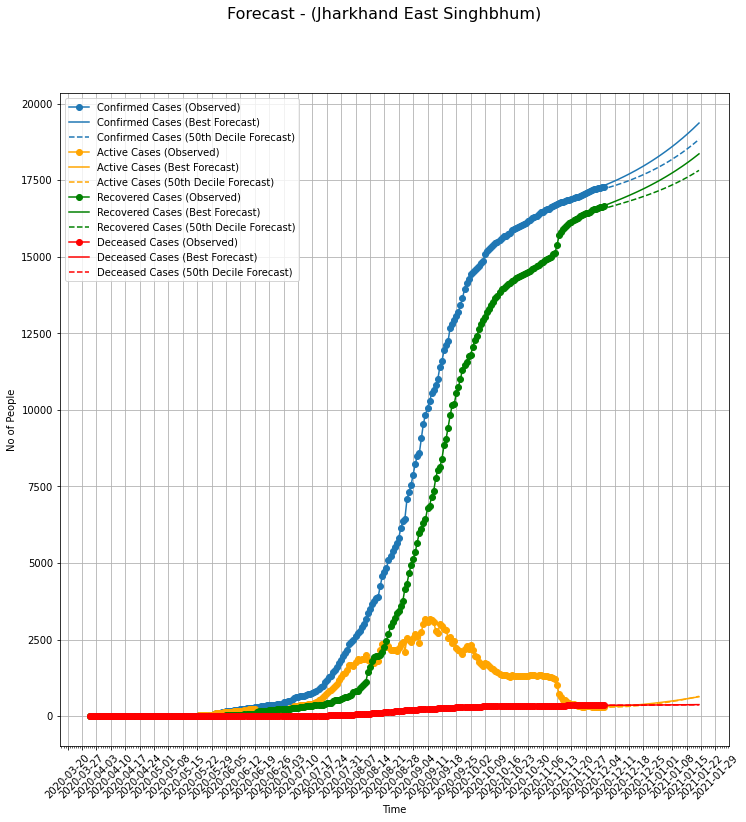

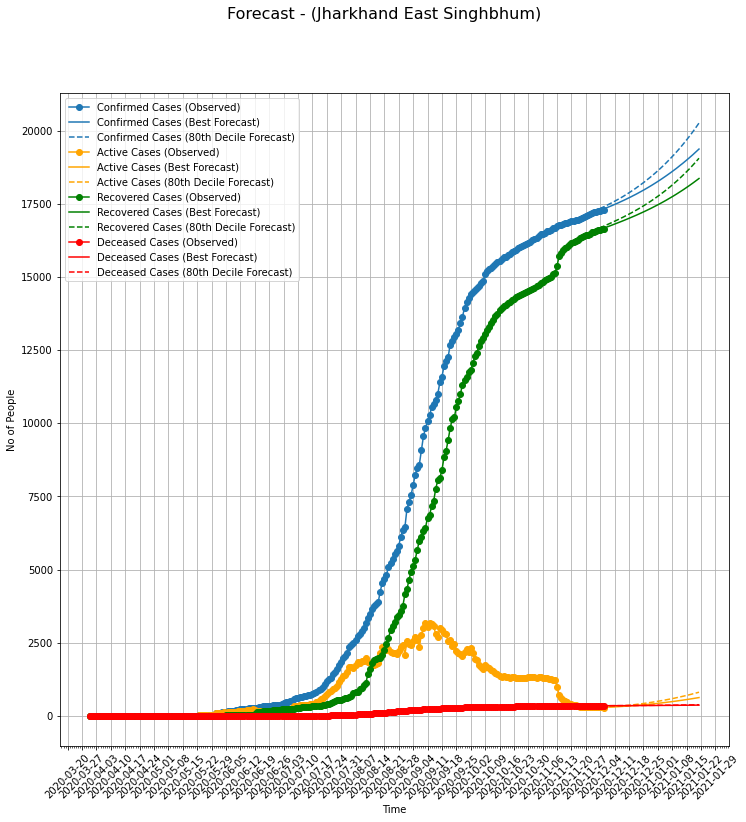

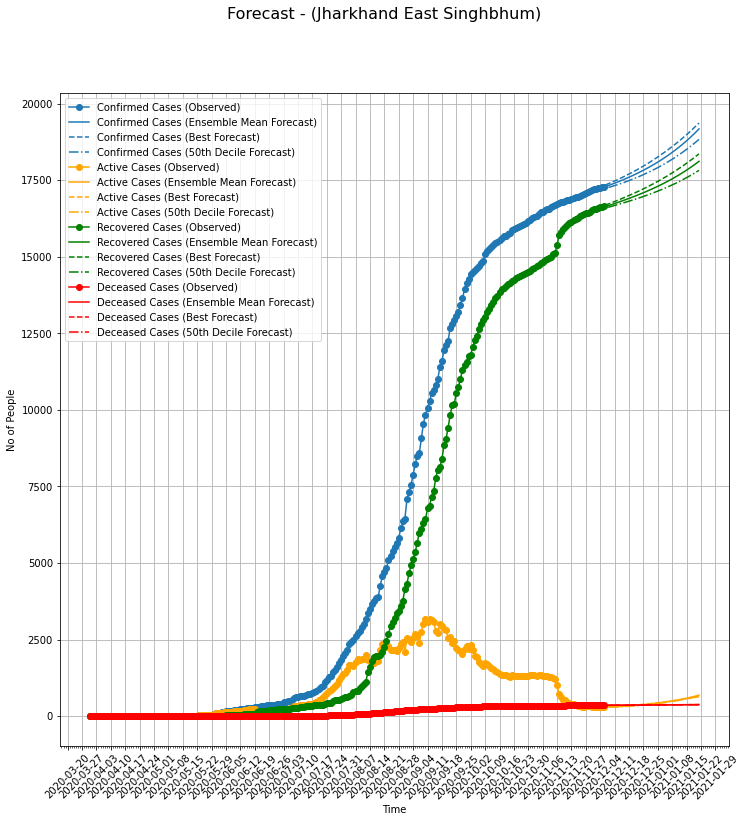

In [42]:
predictions_dict['m2']['plots']['forecast_best_50'] = plot_forecast(predictions_dict, 
                                                                    (config['fitting']['data']['dataloading_params']['state'], 
                                                                     config['fitting']['data']['dataloading_params']['district']),
                                                                    fits_to_plot=['best', 50], error_bars=False)
predictions_dict['m2']['plots']['forecast_best_80'] = plot_forecast(predictions_dict, 
                                                                    (config['fitting']['data']['dataloading_params']['state'], 
                                                                     config['fitting']['data']['dataloading_params']['district']),
                                                                    fits_to_plot=['best', 80], error_bars=False)
predictions_dict['m2']['plots']['forecast_ensemble_mean_50'] = plot_forecast(predictions_dict, 
                                                                             (config['fitting']['data']['dataloading_params']['state'], 
                                                                              config['fitting']['data']['dataloading_params']['district']),
                                                                             fits_to_plot=['ensemble_mean', 'best', 50], error_bars=False)

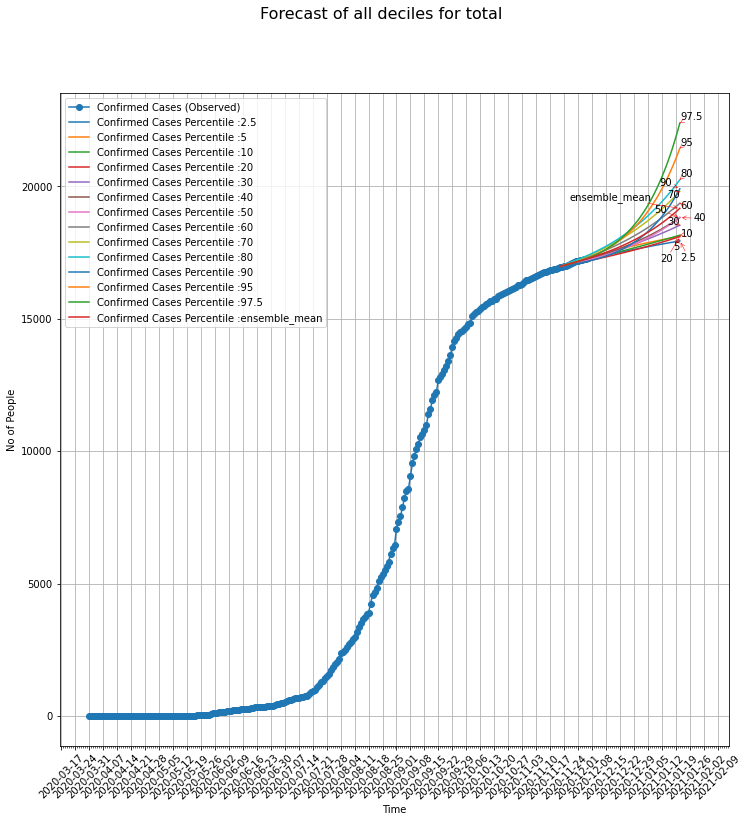

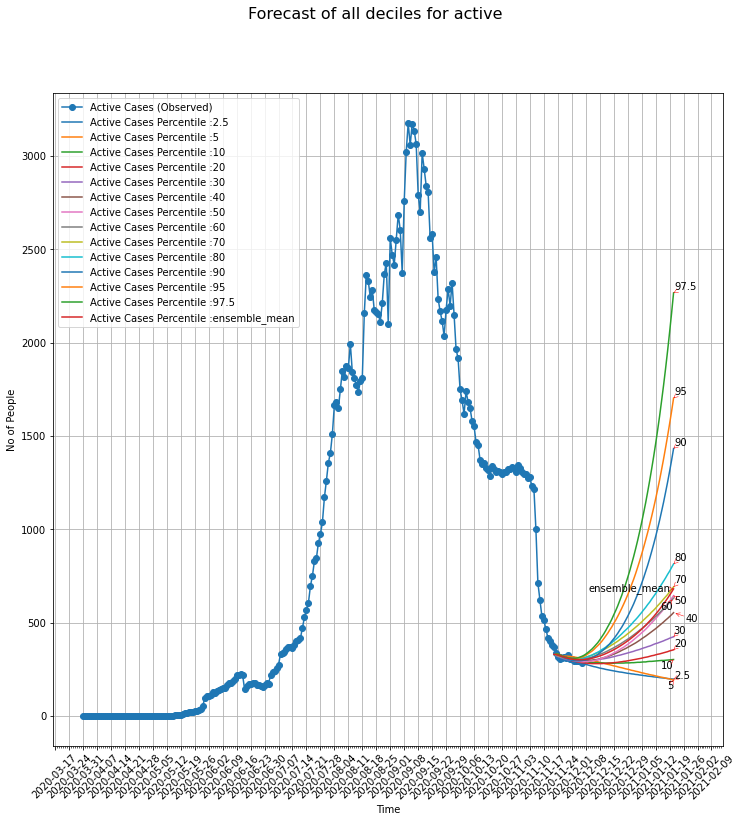

In [43]:
ptiles_plots = plot_ptiles(predictions_dict, which_compartments=config['forecast']['plot_ptiles_for_columns'])
predictions_dict['m2']['plots']['forecasts_ptiles'] = {}
for column in config['forecast']['plot_ptiles_for_columns']:
    predictions_dict['m2']['plots']['forecasts_ptiles'][column.name] = ptiles_plots[column]

## What If Scenarios - R0 Multipliers

getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..


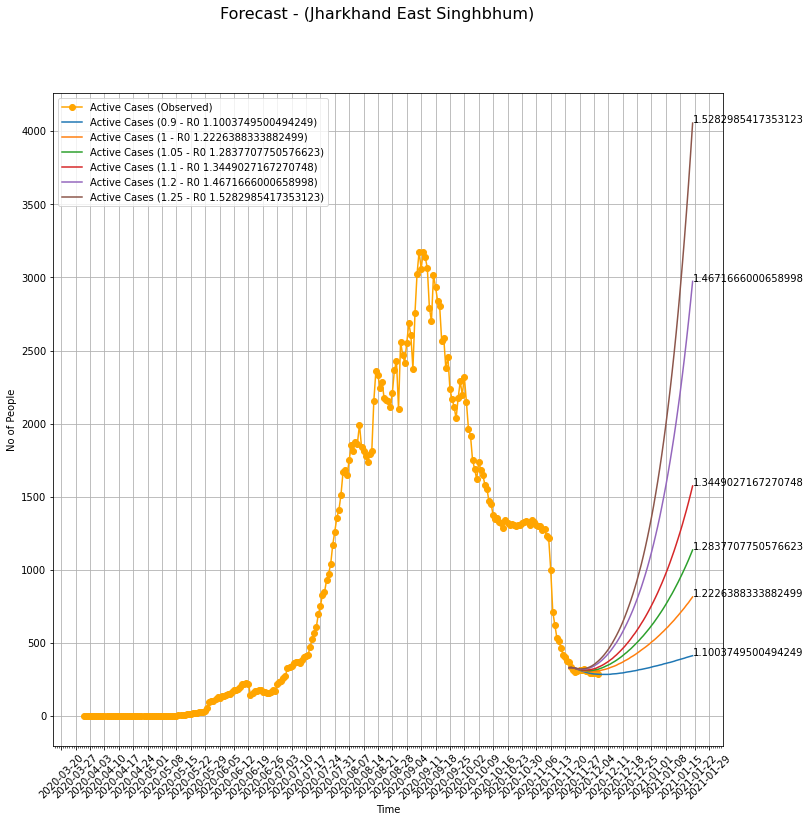

In [44]:
r0_mul_params= predictions_dict['m2']['deciles'][config['what_ifs']['percentile']]['params']
predictions_dict['m2']['r0_mul_dict'] = predict_r0_multipliers(predictions_dict, r0_mul_params, model=config['fitting']['model'],            days=config['forecast']['forecast_days'], multipliers=config['what_ifs']['multipliers'])
predictions_dict['m2']['plots']['r0_mul_dict'] = plot_r0_multipliers(predictions_dict, None, predictions_dict['m2']['r0_mul_dict'], None, config['fitting']['data']['dataloading_params']['state'], config['fitting']['data']['dataloading_params']['district'])

## Plot Trends on ground

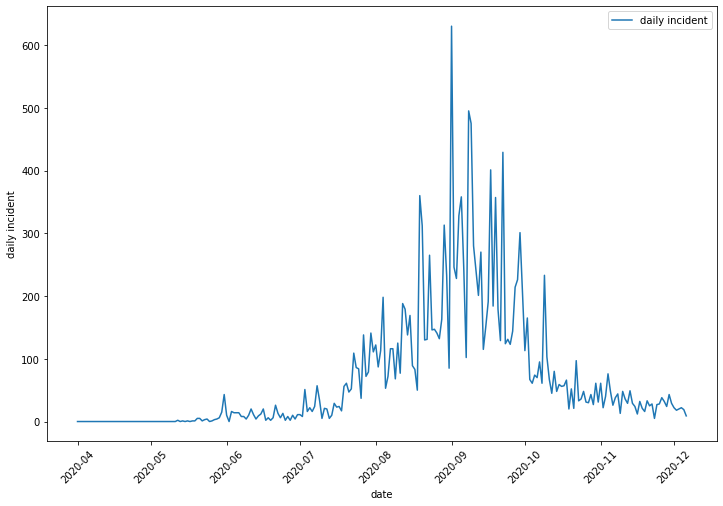

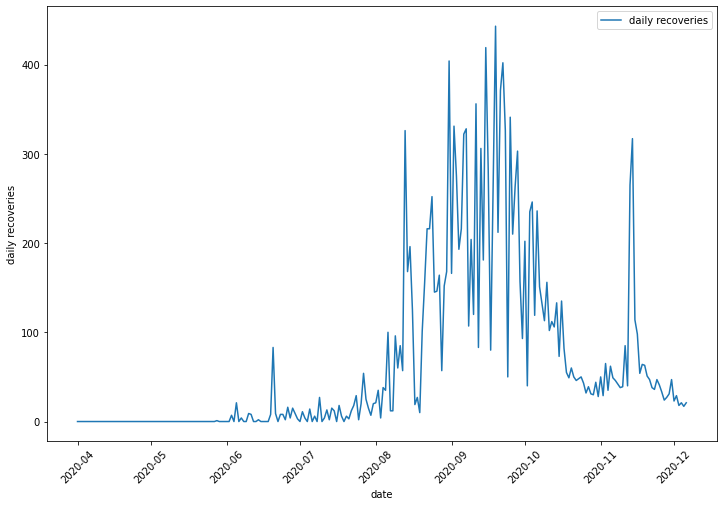

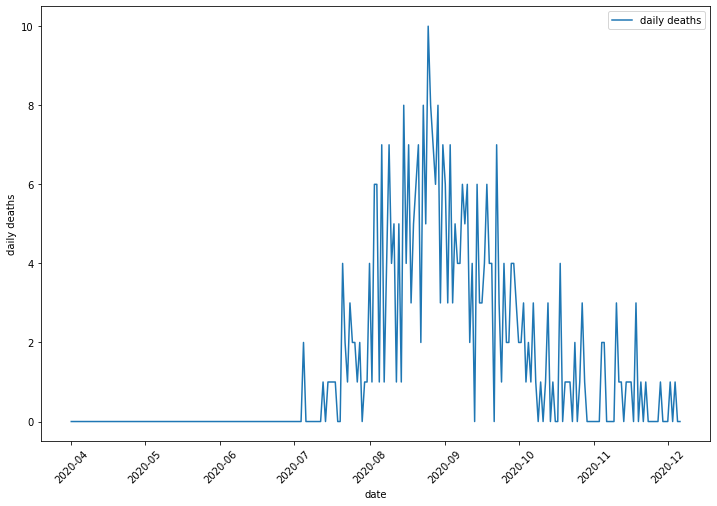

In [45]:
predictions_dict['m0']['plots']['trends'] = {}
predictions_dict['m0']['plots']['trends']['daily_incident'] = plot_daily_trend(predictions_dict['m0']['df_district'], which_trend='incident')
predictions_dict['m0']['plots']['trends']['daily_recoveries'] = plot_daily_trend(predictions_dict['m0']['df_district'], which_trend='recoveries')
predictions_dict['m0']['plots']['trends']['daily_deaths'] = plot_daily_trend(predictions_dict['m0']['df_district'], which_trend='deaths')

## Create Report

In [46]:
save_dict_and_create_report(predictions_dict, config, ROOT_DIR=output_folder, config_filename=config_filename)

## Create Output

In [47]:
df_output = create_decile_csv_new(predictions_dict)
df_output.to_csv(f'{output_folder}/deciles.csv')

## Create All Trials Output

In [48]:
df_all = create_all_trials_csv(predictions_dict)
df_all.to_csv(f'{output_folder}/all_trials.csv')

## Create R0 Multiplier Output

In [49]:
save_r0_mul(predictions_dict['m2']['r0_mul_dict'], output_folder)

## Create df_district Output

In [50]:
predictions_dict['m1']['df_district'].to_csv(f'{output_folder}/df_district.csv')